## Google Colab Setup

### Setting up Google Colab with GPU support is a straightforward process. Here are the steps along with links to the official documentation:

1. Open Google Colab:
   Open your browser and go to Google Colab.

2. Sign in with Google Account:
   If you're not already signed in, sign in with your Google account.

3. Create a New Notebook:
   Click on "File" in the top left corner, then select "New Notebook" to create a new Colab notebook.

4. Change Runtime Type:
   Click on "Runtime" in the top menu, then select "Change runtime type." Choose "GPU" from the Hardware accelerator dropdown menu.

[Change runtime type documentation](https://colab.research.google.com/notebooks/basic_features_overview.ipynb#scrollTo=-_z3tY2D-RRs)

5. Verify GPU Availability:
   To verify that the GPU is successfully connected, you can run the following code snippet in a code cell:
   ```python
   import tensorflow as tf
   tf.test.gpu_device_name()
   ```
   It should output the name of your GPU if the GPU is connected.


6. Load Data and Start Coding:
   Now you can start coding in your notebook. Upload your datasets, write your code, and execute the cells.

   Remember that the GPU access provided by Colab is not unlimited. It has time restrictions, and if you exceed the allocated time, you might need to reconnect to a new GPU.

   By following these steps and referring to the provided documentation links, you should be able to set up and use Google Colab with GPU support for your machine learning or deep learning projects.





## Coding Exercise

### Simple Neural Network Implementation

Objective: Complete a simple neural network.
This task will help you understand the fundamental mechanisms of neural networks, including the forward pass, backward pass (backpropagation), and basic optimization.

Problem Statement:
You are given a neural network that is performing really bad.
You are required to complete and improve it to perform  classification on a Fashion MNIST Dataset

Import all necessary libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler
import tensorflow as tf

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tf.test.gpu_device_name()

'/device:GPU:0'

### Dataset:

The dataset used is the Fashion-MNIST dataset, a dataset of Zalando's article images. It is intended as a drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It consists of 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image, associated with a label from 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot.

### Train, Validation & Test split

- **Splitting the Dataset:** The dataset is split into training and testing sets. The `train=True` argument is used to load the training set, and `train=False` is used to load the testing set.

- **Creating a Validation Set:** A validation set is created from the training set. The indices of the training set are shuffled, and the first 20% of these indices are used for the validation set. The `SubsetRandomSampler` function is used to create samplers for the training and validation sets, which can be used to load batches of data.

In [4]:
## Fashion MNIST data loading
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples),
                                                                      # therefore we should add a comma after the values

#Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

#Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.96MB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.24MB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.72MB/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



#### Sequential Model

The neural network model is defined as a `Sequential` model. The `Sequential` model is a linear stack of layers. It can be created by passing a list of layer instances to the constructor.


In [43]:
class Classifier(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120,10)
        self.act = activation()
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(self.act(self.fc1(x)))
        #not using dropout on output layer
        x = F.tanh(self.fc2(x))

        return x

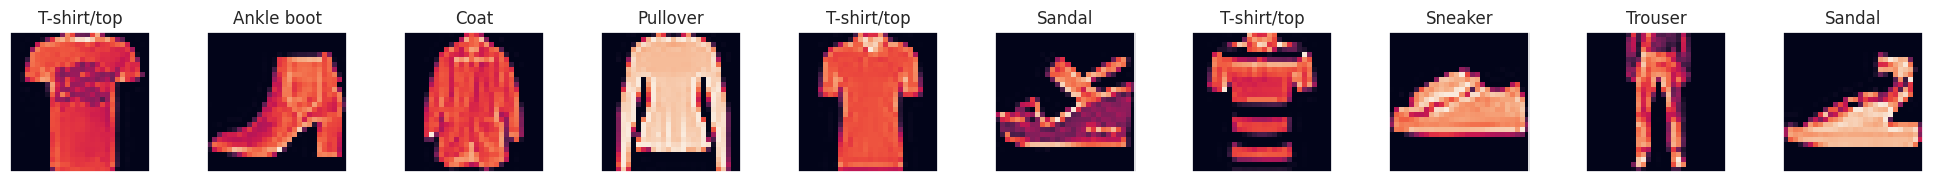

In [44]:
# visualizing images in gird
def imshow(img):
    img = img/2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert from tensor image

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() #converting images to numpy for display

fig = plt.figure(figsize=(25,4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(trainset.classes[labels[idx]])


### Training Function:
This function trains the neural network model with stochastic gradient descent (SGD) as the optimizer and cross-entropy as the loss objective function.
The training process includes both forward and backward passes. The model's parameters are updated in each epoch.

### Testing Function:
After training the model, we'll evaluate the model's performance on testing dataset. The evaluation will be done based on the accuracy of the model, which is the proportion of correctly predicted samples.

In [45]:
class ModelTrainer:
    def __init__(self, model, learning_rate=1, num_epochs=100, debug=True):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.train_loss = []
        self.test_loss = []
        self.debug = debug

    def train_model(self, loader, epoch):
        self.model.train()
        loss_list = []
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_func(output, target)
            loss.backward()
            self.optimizer.step()
            loss_list.append(loss.item())

        if self.debug:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                          epoch, batch_idx*len(data), len(loader.dataset),
                          100. * batch_idx / len(loader), loss.item()))

        avg_loss = sum(loss_list)/len(loss_list)
        self.train_loss.append(avg_loss)


    def test_model(self, loader):
        self.model.eval()
        test_loss = 0
        correct = 0
        loss_list = []
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(self.device), target.to(self.device)
                y_true.extend(target.cpu().numpy())

                output = self.model(data)
                batch_loss = self.loss_func(output, target).item()  # Calculate the loss for this batch
                test_loss += batch_loss  # Add the batch loss to the total test loss
                pred = output.argmax(dim=1, keepdim=True)

                y_pred.extend(pred.squeeze(dim=1).tolist())
                correct += pred.eq(target.view_as(pred)).sum().item()
                loss_list.append(batch_loss)  # Append the batch loss to the list

        avg_loss = sum(loss_list) / len(loss_list)
        self.test_loss.append(avg_loss)
        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)

        if self.debug:
          print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                  test_loss, correct, len(loader.dataset), accuracy))

        return y_true, y_pred

    def run(self, trainloader, validloader):
        for epoch in range(self.num_epochs):
            self.train_model(trainloader, epoch)
            self.test_model(validloader)
        self.plot_loss()


    def plot_loss(self):
      epochs = range(1, self.num_epochs + 1)

      plt.plot(epochs, self.train_loss, label='Training Loss')
      plt.plot(epochs, self.test_loss, label='Test Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)
      plt.show()


Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.149329

Test set: Average loss: 0.0153, Accuracy: 33578/60000 (56%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.997584

Test set: Average loss: 0.0139, Accuracy: 37285/60000 (62%)



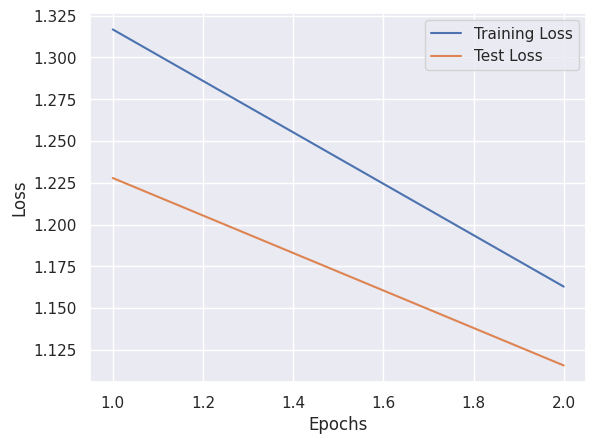


Test set: Average loss: 0.0177, Accuracy: 7645/10000 (76%)



In [47]:
model = Classifier()
trainer = ModelTrainer(model=model, learning_rate=0.5, num_epochs=2)
trainer.run(trainloader, validloader)
y_true, y_pred = trainer.test_model(testloader)

#### Task 1: Visualize the model's correct and incorrect predictions on the testing dataset using a confusion Matrix.(10 pts)

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set_theme()

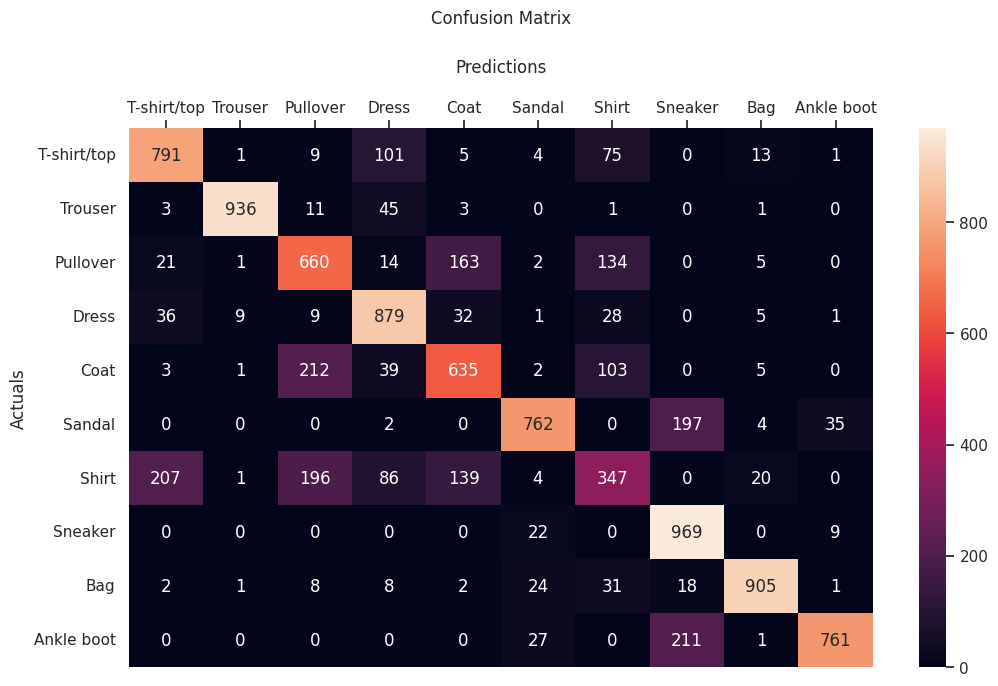

In [49]:
plt.figure(figsize=(12, 7))
sns.heatmap(
    confusion_matrix(y_true, y_pred),
    annot=True,
    fmt='g',
    cbar=True,
    xticklabels=datasets.FashionMNIST.classes,
    yticklabels=datasets.FashionMNIST.classes
)

plt.xlabel('Predictions', labelpad=20)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.ylabel('Actuals')
plt.title('Confusion Matrix', pad=25)

plt.show()

### Machine learning involves a lot of experimentation. You might not always see large improvements, but every observation helps you understand how different parameters and design choices affect the model's performance. Focus on interpreting the results, not just achieving the best accuracy.

In [1]:
# Make PyTorch models look like scikit-learn models so we can leverage
# scikit-learns hyper-parameter tuning abilities.
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 15.6 MB/s eta 0:00:00


In [55]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

'''
While Skorch's fit function accepts a pytorch dataset it runs much slower when
used so we unwrap it while still applying the original transforms.
'''
X = torch.stack([transform(img.numpy()) for img in trainset.data])
y = trainset.targets
X_test = torch.stack([transform(img.numpy()) for img in testset.data])
y_test = testset.targets.numpy()
row_labels = ['Epochs', 'Learning Rate', 'Activation', 'Accuracy']


def run_training(params):
  training_configs = ParameterGrid(params)
  for i, c in enumerate(training_configs):
    m = NeuralNetClassifier(
        module=Classifier,
        device=device,
        iterator_train__batch_size=64,
        iterator_valid__batch_size=64,
        criterion=nn.CrossEntropyLoss,
        optimizer=optim.SGD,
        lr=c['lr'],
        max_epochs=c['max_epochs'],
        callbacks=[EpochScoring(scoring='accuracy',lower_is_better=False)],
        verbose=0
    )
    m.fit(X, y)

    y_pred = m.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)


    fig = plt.figure(figsize=(14, 4))
    gs = GridSpec(1, 3, width_ratios=[3, 3, 1.5], figure=fig)  # Adjust the width ratio as needed

    ax1 = fig.add_subplot(gs[0, 0])  # First column
    ax2 = fig.add_subplot(gs[0, 1])  # Second column
    ax3 = fig.add_subplot(gs[0, 2])  # Third column for the table

    epochs = range(1, c['max_epochs'] + 1)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.plot(epochs, m.history[:, 'train_loss'], 'o-', label='training')
    ax1.plot(epochs, m.history[:, 'valid_loss'], 'o-', label='validation')
    ax1.set_title('Training & Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()


    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.plot(epochs, m.history[:, 'accuracy'])
    ax2.set_title('Validation Set Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    ax3.axis('off')
    values = [c['max_epochs'], c['lr'], c['module__activation'].__name__, f'{accuracy * 100:.2f}%']
    table = ax3.table(
        cellText=[[row, value] for row, value in zip(row_labels, values)],
        loc='top',
        cellLoc='left',
        bbox=[-0.1, 0.25, 1.25, .75]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.auto_set_column_width(col=range(2))


    plt.tight_layout()
    plt.show()


#### Task 2: Experiment with different learning rates and report your observations. Explain why the model performs better with some learning rates and worse with others. (10 pts)

For example, Keeping the other parameters the same, pick a high learning rate and observe the lose curve, accuracy. Then pick a low learning rate and observe the lose curve, accuracy. Find an optimal learning rate for your model and explain How learning rate affects the accuracy and lose change? What is the reason for this change?

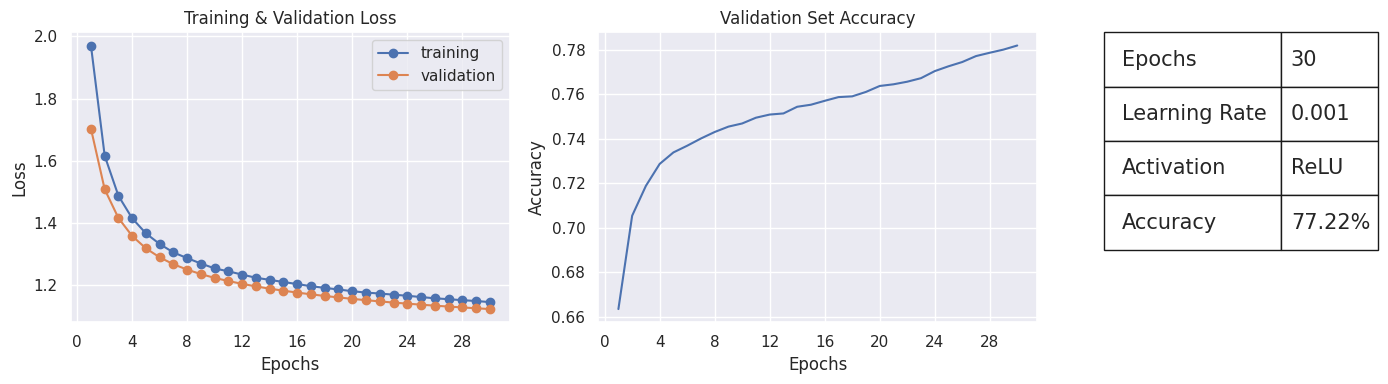

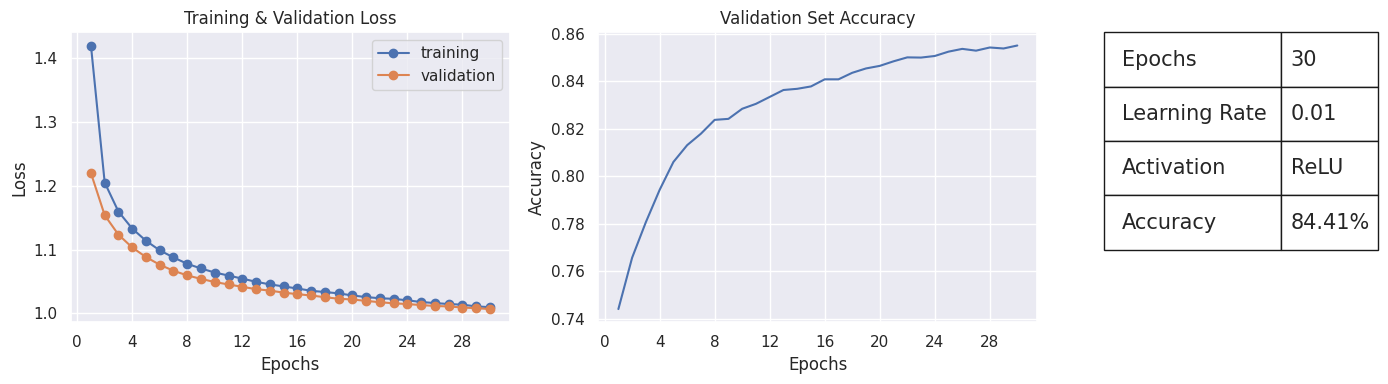

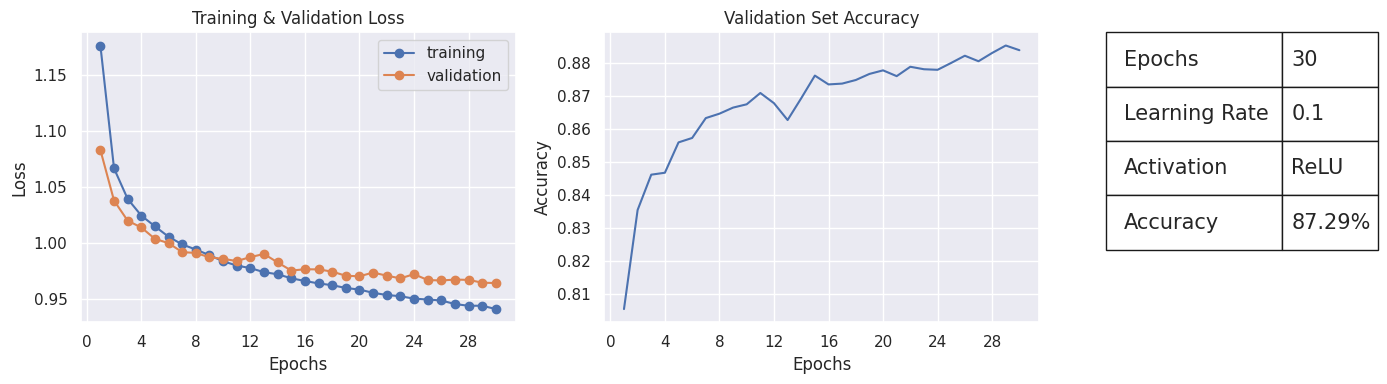

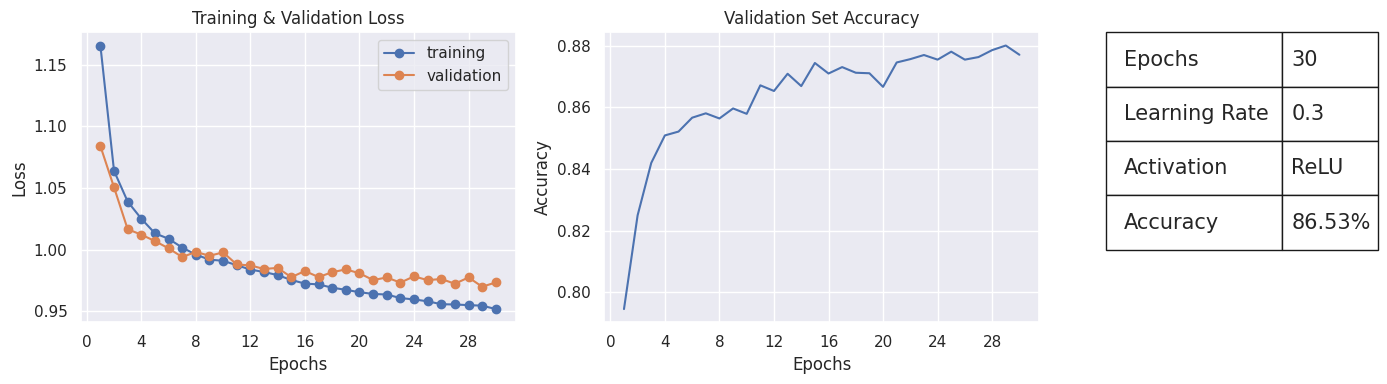

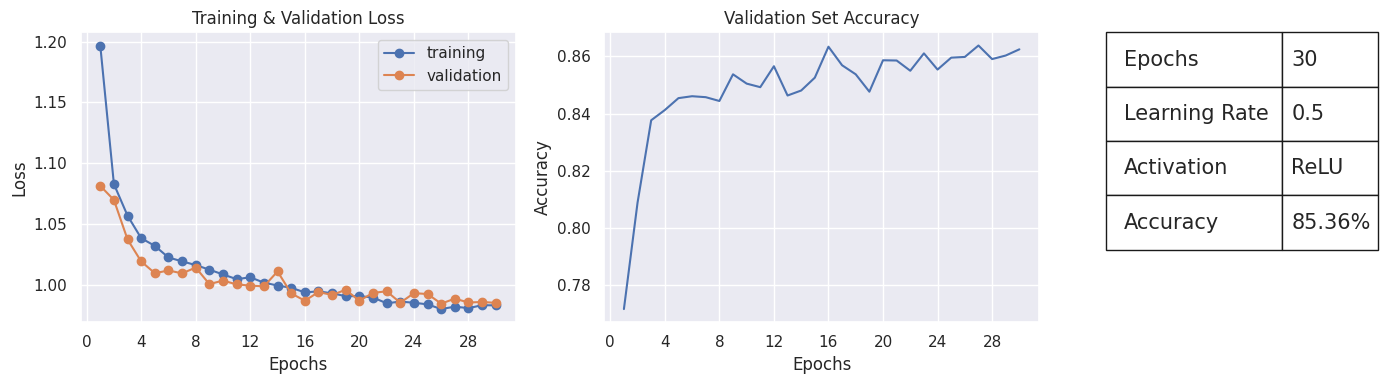

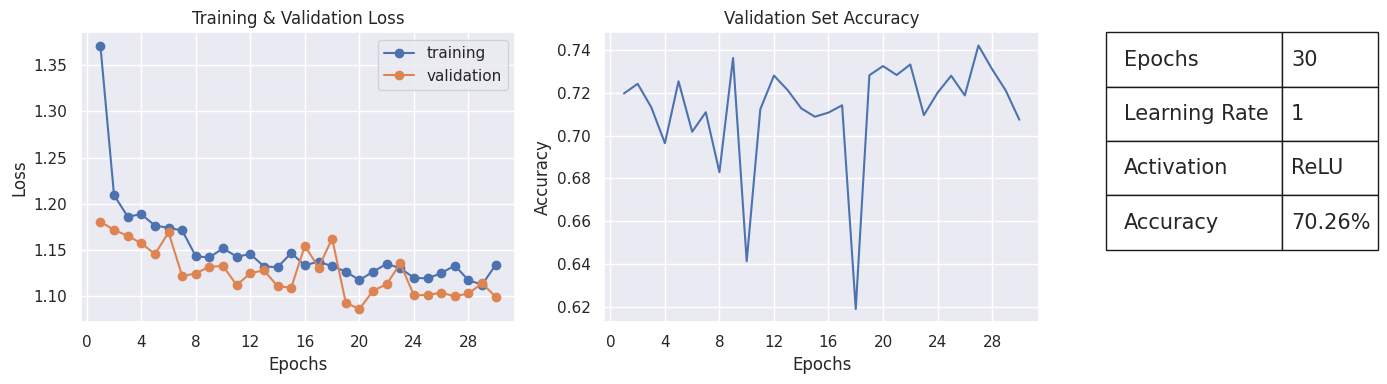

In [56]:
params = {
  'lr': [0.001, 0.01, 0.1, 0.3, 0.5, 1],
  'max_epochs': [30],
  'module__activation': [nn.ReLU]
}

run_training(params)

### Observations


*   The optimial learning rate for the model under test above would be 0.1. That rate has the highest test accuracy while maintaing a consitent downward trend in loss and consistent upward trend in accuracy. All without being too unstable.
*   In contrast the learning rates of > 0.1 result in increasinly unstable training loss and validation accuracy.
*   Rates < 0.1 have lower test accuracies and plateau in the amount training loss which leads to very increases in validation accuracy.
*   Lastly, there does appear to be a relationship between an optimal learning rate and the number of epochs. The more stable trains all start to plateau around 10 epochs.





#### Task 3: Experiment and report your observations on how the model's performance changes using *three* different activation functions. (10 pts)
Read more here: [Activation functions](https://machinelearningmastery.com/activation-functions-in-pytorch/)

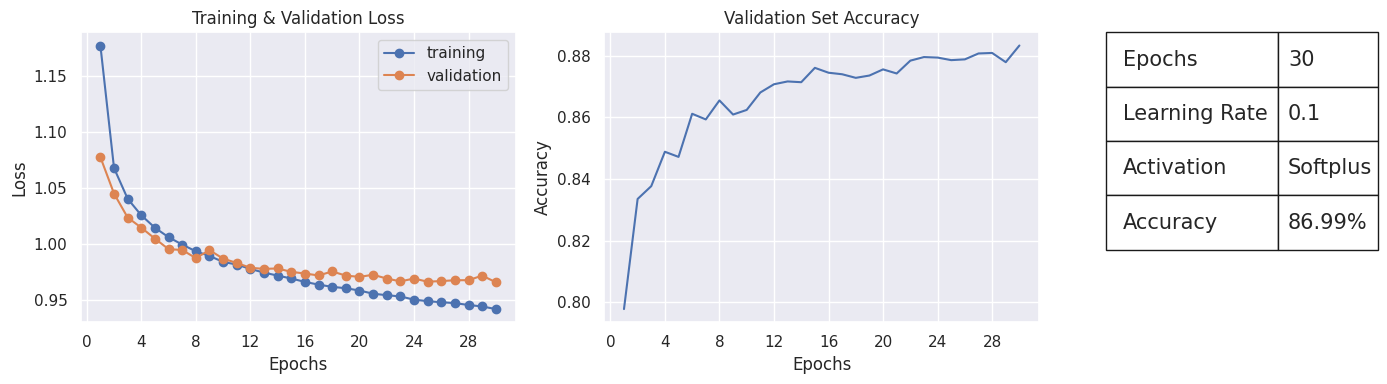

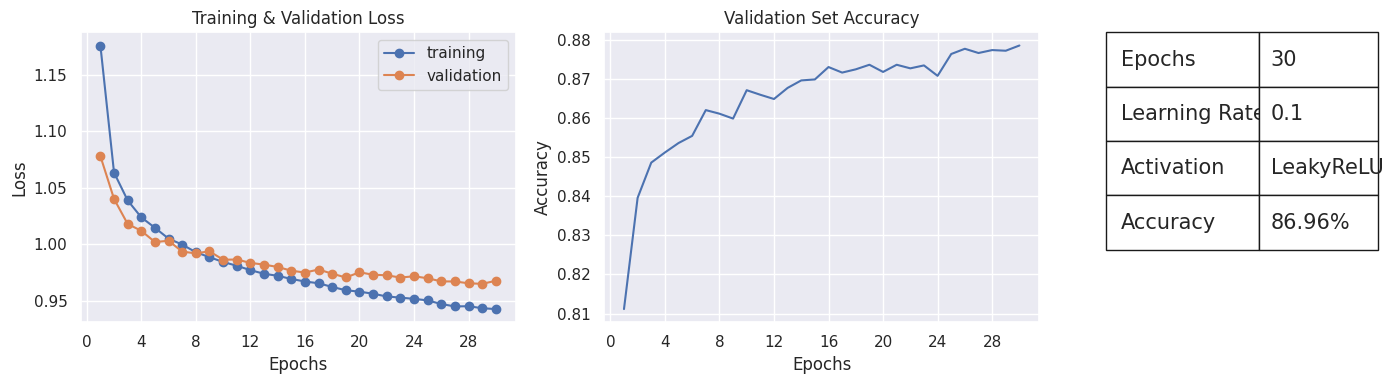

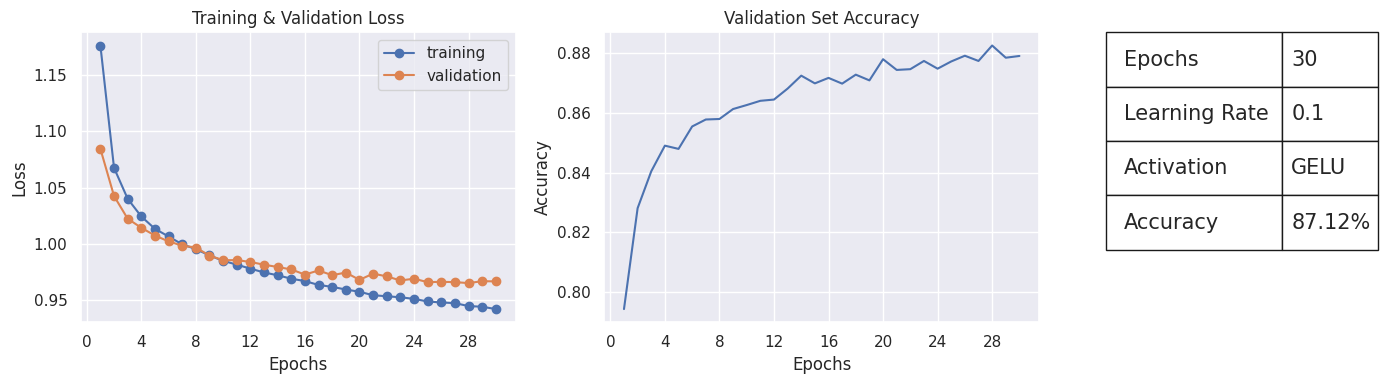

In [57]:
params = {
  'lr': [0.1], # best learning rate from above
  'max_epochs': [30],
  'module__activation': [nn.Softplus, nn.LeakyReLU, nn.GELU]
}

run_training(params)

### Observations

* Using the same number of epochs and the best learning rate from above none of the activation functions in the experiment performed better than ReLU.
* All the activation functions had similiar trends in training loss and validation accuracy, which may imply that the learning rate is what is critical. More experiments with the other activation functions is necessary.

#### Task 4: Experiment and report your observations on how the model's performance(testing accuracy) changes with different numbers of hidden neurons and different number of hidden layers. (15 pts)
For example pick a hidden layer with 1000 neurons and report the accuracy. Then pick a hidden layer with 10 neurons and report the accuracy. How does the accuracy change, how long does it take for each iteration? What is the reason for this change?


In [ ]:
######################################
######## WRITE YOUR CODE HERE ########
######################################

#### Task 5: What did you learn from these experiments? (10 pts)

* A more thorough empirical investation would be needed to better understand the relationships between variables. For example

## Exploring Web Interfaces of Large Language Models

### Objective:
This section is designed to help you become familiar with web interfaces of popular AI tools, including OpenAI GPT, Perplexity, and Grok. You will explore how these tools handle different types of prompts.
This exercise will help you understand and compare the capabilities and limitations of different large language model-based tools, providing insights into their real-world applications.

The task is to experiment with atleast 3 tools to compare and gain insights on how my perform and their limitations.

### Part 1: Task: Exploring Role-Specific Prompting (10 pts)
1. General Prompt:

Ask the tool a simple question, such as:
   - "How does a neural network work?"
   - "Explain how a recommendation system works."

2. Role-Specific Prompt:

Frame the same question by assigning a professional role to the tool. For example:
   - "You are a professor with 20 years of experience in machine learning. Explain how a neural network works."
   - "You are a data scientist working on Netflix's recommendation systems. Explain how a recommendation system works."
   
Observe and document how the response changes in detail, tone, and focus.

### Part 2: Math and Reasoning (10 pts)
1. Using the same three tools, provide prompts requiring logical reasoning and mathematical calculations. For instance:
   - "What is the sum of 123 and 456?"
   - "If it takes 3 hours to travel 180 miles, what is the speed in miles per hour?"
2. Compare the outputs for accuracy and coherence.


### Submission Instructions
- Take screenshots of the prompts and the corresponding responses for both tasks.
- Compile the screenshots into a single Zip file.
- Submit your document via the assignment portal.



## OpenAI API Setup Instructions

### Step 1: Create an OpenAI Account
Go to the [OpenAI website](https://beta.openai.com/signup/) and create an account.
### Step 2: Get Your API Key
Once you've created an account and logged in, navigate to the API section in the dashboard. Here, you will have to create your own API key. Make sure to Copy this key for later use.

Note: You might need to make a minimum payment to use the API calls. You will be charged as per the number of API calls made. [Pricing](https://openai.com/api/pricing/)
### Step 3: Install the OpenAI Python Client
You can install the OpenAI Python client using pip. Open your terminal and run the following command:
```console
pip install openai
```
### Step 4: Use the API Key in Your Application
In your Python script, you can use the API key like this:

```python
import openai

openai.api_key = 'your-api-key'
```

Replace `'your-api-key'` with the API key you copied earlier.

### Step 5: Make API Calls
Now you can make API calls using the `openai` library. For example, to use the GPT-3 model, you can do something like this:
#### For Text Generation
```python
messages = [{"role": "user", "content": prompt}]
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=1,
    )
```

#### For Image Generation
```python
response = client.images.generate(
        model="dall-e-2",
        prompt= "Birthday cake with candles",
        n=1,
        size="1024x1024"
    )

That's it! You've successfully set up the OpenAI API.
For more Usages and examples refer the Docs Section
```

## OpenAI Setup Assignment

After successfully setting up the OpenAI API, you can now use it to complete the assignment. The assignment is divided into two parts:

### Part 1: Sentiment Analysis (10 pts)
In this part, you'll use the OpenAI API to generate text. You'll use the GPT-3 model for this task. Take input from the user and perform sentiment analysis on the input text. Based on the sentiment, generate a response using the GPT-3 model.

### Part 2: Image Generation (5 pts)
In this part, you'll use the OpenAI API to generate images. You'll use the DALL-E model for this task. Take input from the user and generate an image based on the input text.

 ###  *Store your API key in a file called open_ai_key.txt and upload it on Colab or give path to the text file if you are running it locally*


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import openai
from openai import OpenAI
from PIL import Image
import urllib.request
from io import BytesIO
from IPython.display import display

class open_ai_a0:
    def __init__(self):
        api_key = self.load_key()
        self.client = OpenAI(api_key=api_key)

    # Loading OpenAI key from file #
    def load_key(self):
        open_ai_key_file = "open_ai_key.txt"
        with open(open_ai_key_file, "r") as f:
            for line in f:
                OPENAI_KEY = line.strip()  # strip to remove any trailing newline character
                return OPENAI_KEY

    def get_sentiment(self, text):
        # TODO: Write your prompt here for sentiment analysis on user provided text
        ######################################
        ######## WRITE YOUR PROMPT HERE ########
        ######################################
        prompt = ""
        messages = [{"role": "user", "content": prompt}]
        response = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            temperature=1,
        )

        sentiment = response.choices[0].message.content
        print(sentiment)

    def text_to_image(self):
        response = self.client.images.generate(
            model="dall-e-2",
            # TODO: Write your prompt here for text to image
            ######################################
            ######## WRITE YOUR PROMPT HERE ########
            ######################################
            prompt= "",
            n=1,
            size="1024x1024"
        )
        image_url = response.data[0].url
        with urllib.request.urlopen(image_url) as image_url:
            img = Image.open(BytesIO(image_url.read()))

        display(img)


    def run(self):
        text = input("Enter a text: ")
        self.get_sentiment(text)
        self.text_to_image()

In [ ]:
if __name__ == "__main__":
    obj = open_ai_a0()
    obj.run()